In [1]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

import pvlib

import matplotlib.pyplot as plt  # for visualization


Adapted from examples here: https://github.com/PV-Tutorials/PVSC48-Python-Tutorial/tree/main

In [2]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 52.52,
    "longitude": 13.41,
    "start_date": "2021-01-01",
    "end_date": "2021-12-31",
    "hourly": ["temperature_2m", "wind_speed_10m", "shortwave_radiation", "diffuse_radiation", "direct_normal_irradiance"],
    "wind_speed_unit": "ms",
    "timezone": "GMT"
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process hourly data. The order of variables needs to be the same as requested.
hourly = response.Hourly()
hourly_temperature_2m = hourly.Variables(0).ValuesAsNumpy()
hourly_wind_speed_10m = hourly.Variables(1).ValuesAsNumpy()
hourly_shortwave_radiation = hourly.Variables(2).ValuesAsNumpy()
hourly_diffuse_radiation = hourly.Variables(3).ValuesAsNumpy()
hourly_direct_normal_irradiance = hourly.Variables(4).ValuesAsNumpy()

hourly_data = {"date": pd.date_range(
    start = pd.to_datetime(hourly.Time(), unit = "s", utc = True),
    end = pd.to_datetime(hourly.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = hourly.Interval()),
    inclusive = "left"
)}
hourly_data["temperature_2m"] = hourly_temperature_2m
hourly_data["wind_speed_10m"] = hourly_wind_speed_10m
hourly_data["GHI"] = hourly_shortwave_radiation
hourly_data["DHI"] = hourly_diffuse_radiation
hourly_data["DNI"] = hourly_direct_normal_irradiance

hourly_df = pd.DataFrame(data = hourly_data)
hourly_df = hourly_df.set_index("date")
print(hourly_df)

Coordinates 52.5483283996582°N 13.407821655273438°E
Elevation 38.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                           temperature_2m  wind_speed_10m  GHI  DHI  DNI
date                                                                    
2021-01-01 00:00:00+00:00        0.558500        1.972308  0.0  0.0  0.0
2021-01-01 01:00:00+00:00        0.558500        1.749286  0.0  0.0  0.0
2021-01-01 02:00:00+00:00        0.158500        1.749286  0.0  0.0  0.0
2021-01-01 03:00:00+00:00        0.658500        1.749286  0.0  0.0  0.0
2021-01-01 04:00:00+00:00        0.808500        1.581139  0.0  0.0  0.0
...                                   ...             ...  ...  ...  ...
2021-12-31 19:00:00+00:00       11.258500        6.826419  0.0  0.0  0.0
2021-12-31 20:00:00+00:00       11.258500        7.324616  0.0  0.0  0.0
2021-12-31 21:00:00+00:00       11.058500        7.025667  0.0  0.0  0.0
2021-12-31 22:00:00+00:00       10.808500        6.200806  0.0  0.0  0.0

In [3]:

# make a Location object 
location = pvlib.location.Location(latitude=params['latitude'],
                                   longitude=params['longitude'])

In [4]:
# Note: open_meteo  datasets are right-labeled hourly intervals, e.g. the
# 10AM to 11AM interval is labeled 11.  We should calculate solar position in
# the middle of the interval (10:30), so we subtract 30 minutes:
times = hourly_df.index - pd.Timedelta('30min')
solar_position = location.get_solarposition(times)
# but remember to shift the index back to line up with the TMY data:
solar_position.index += pd.Timedelta('30min')

solar_position.head()

,apparent_zenith,zenith,apparent_elevation,elevation,azimuth,equation_of_time
date,,,,,,
2021-01-01 00:00:00+00:00,150.229937,150.229937,-60.229937,-60.229937,9.398820,-3.421489
2021-01-01 01:00:00+00:00,146.744349,146.744349,-56.744349,-56.744349,35.131254,-3.441097
2021-01-01 02:00:00+00:00,140.228680,140.228680,-50.228680,-50.228680,55.714077,-3.460697
2021-01-01 03:00:00+00:00,132.047059,132.047059,-42.047059,-42.047059,71.833457,-3.480288
2021-01-01 04:00:00+00:00,123.118376,123.118376,-33.118376,-33.118376,85.156378,-3.499870


In [5]:
df_poa = pvlib.irradiance.get_total_irradiance(
    surface_tilt=params['latitude'],  
    surface_azimuth=180,  # facing South
    dni=hourly_df['DNI'],
    ghi=hourly_df['GHI'],
    dhi=hourly_df['DHI'],
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'],
    model='isotropic')

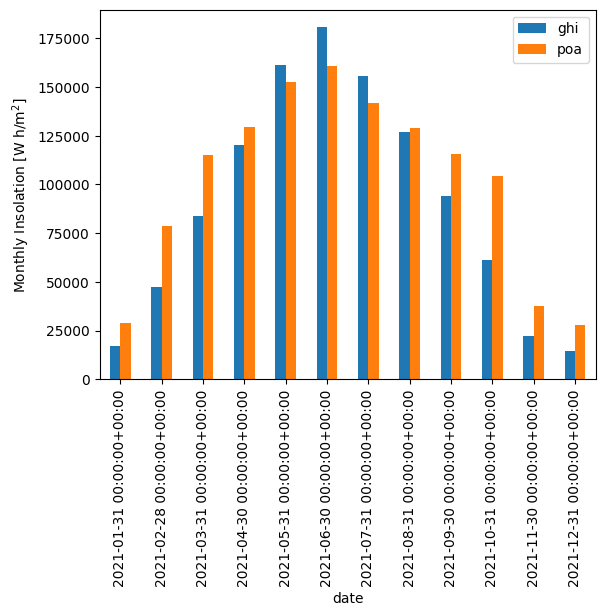

In [6]:
df = pd.DataFrame({
    'ghi': hourly_df['GHI'],
    'poa': df_poa['poa_global'],
})
df_monthly = df.resample('ME').sum()
df_monthly.plot.bar()
plt.ylabel('Monthly Insolation [W h/m$^2$]');

open_rack_glass_polymer is appropriate for many large-scale systems (polymer backsheet; open racking), so we will use it here:

In [7]:

all_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']
parameters = all_parameters['open_rack_glass_polymer']


In [8]:
cell_temperature = pvlib.temperature.sapm_cell(
    df_poa['poa_global'], hourly_df['temperature_2m'],
    hourly_df['wind_speed_10m'], **parameters)


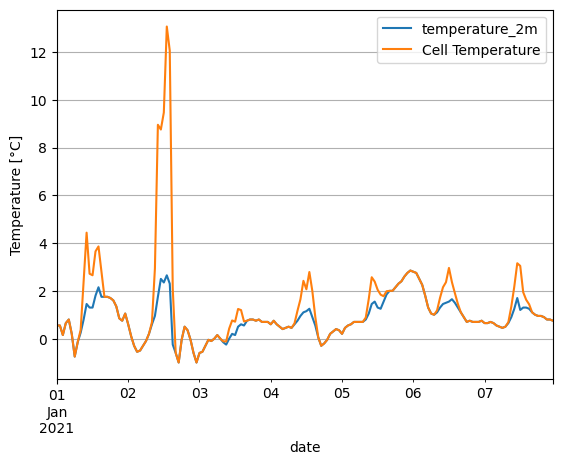

In [9]:
hourly_df['temperature_2m'].head(24*7).plot()
cell_temperature.head(24*7).plot()
plt.grid()
plt.legend(['temperature_2m', 'Cell Temperature'])
# note Python 3 can use unicode characters like the degrees symbol
plt.ylabel('Temperature [°C]');

 assume a 1kW array with a temperature coefficient of -0.4%/°C:

In [10]:
gamma_pdc = -0.004  # divide by 100 to go from %/°C to 1/°C
nameplate = 1e3
area = nameplate/200 #area in m2

array_power = pvlib.pvsystem.pvwatts_dc(df_poa['poa_global'], cell_temperature, nameplate, gamma_pdc)

In [ ]:
meantemp = cell_temperature *0 + cell_temperature.mean()
array_power_ct = pvlib.pvsystem.pvwatts_dc(df_poa['poa_global'], meantemp, nameplate, gamma_pdc)


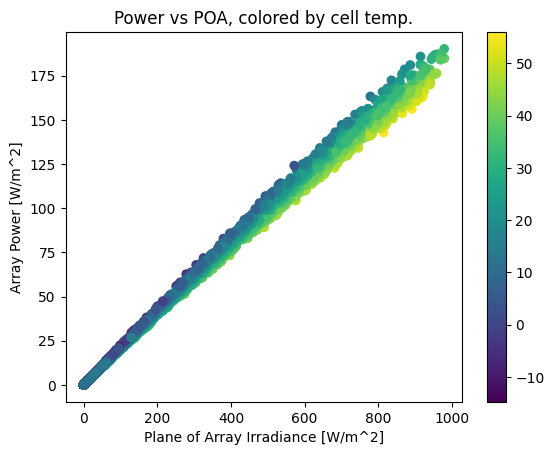

In [11]:
plt.scatter(df_poa['poa_global'], array_power/area, c=cell_temperature)
plt.colorbar()
plt.ylabel('Array Power [W/m^2]')
plt.xlabel('Plane of Array Irradiance [W/m^2]')
plt.title('Power vs POA, colored by cell temp.');

In [ ]:
df_plot = pd.DataFrame({
    'Plane of Array Irradiance': df_poa['poa_global'],
    'Production': array_power/area,
})
# summing hourly power (W) gives (W h)
df_plot.resample('ME').sum().plot()
plt.ylabel('Energy [Wh]')

In [ ]:
df_plot_resampled = df_plot.resample('ME').sum()*1e-3
cell_temperature_resampled = cell_temperature.resample('ME').mean()

idx = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig, ax1 = plt.subplots()

ax1.plot(idx, df_plot_resampled['Plane of Array Irradiance'], 'g--', label='Plane of Array Irradiance')
ax1.plot(idx, df_plot_resampled['Production'], 'g-', label='Production')
ax1.set_ylabel('Energy [kWh]', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.set_ylim(-4/35*200,200)

# Create the second y-axis for Cell Temperature
ax2 = ax1.twinx()
ax2.plot(idx, cell_temperature_resampled, 'r-', label='Cell Temperature')
ax2.set_ylabel('Cell Temperature [°C]', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(-4,35)
ax1.set_xlabel("Months of 2021")

# Add legends for clarity
ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

# Show the plot
plt.show()

In [ ]:
dfkwh = df_plot*1e-3
fig, ax1 = plt.subplots()
idx = dfkwh["2021-06-06 00:00:00+00:00":"2021-06-06 23:00:00+00:00"].index.hour
ax1.plot(idx, dfkwh['Plane of Array Irradiance']["2021-06-06 00:00:00+00:00":"2021-06-06 23:00:00+00:00"], 'g--', label='Plane of Array Irradiance')
ax1.plot(idx, dfkwh['Production']["2021-06-06 00:00:00+00:00":"2021-06-06 23:00:00+00:00"], 'g-', label='Production')
ax1.set_ylabel('Energy [kWh]', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.set_ylim(-0.15,0.9)
ax1.set_xlabel("Hours of 6.6.2021")


# Create the second y-axis for Cell Temperature
ax2 = ax1.twinx()
ax2.plot(idx, cell_temperature["2021-06-06 00:00:00+00:00":"2021-06-06 23:00:00+00:00"], 'r-', label='Cell Temperature')
ax2.set_ylabel('Cell Temperature [°C]', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.set_ylim(10,50)

# Add legends for clarity
ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

# Show the plot
plt.show()

PVWatts has a simplified inverter model. Use pvlib.inverter.pvwatts(pdc, pdc0) to return the AC output given DC output, pdc, and the DC limit, pdc0 which is the AC rated power over the nominal inverter efficiency.

Recall we assumed a 1kW array, so we'll continue the hypothetical case and assume an AC size of 800W, a DC/AC ratio of 1.2. The default PVWatts nominal inverter efficiency is 0.96 which we use to get pdc0.

In [ ]:
pdc0 = 800/0.96  # W
ac = pvlib.inverter.pvwatts(array_power, pdc0)

In [ ]:
plt.rcParams['font.size'] = 14
ax = ac.resample('D').sum().plot(figsize=(15, 10), label='AC')
array_power.resample('D').sum().plot(ax=ax, label='DC')
plt.title('AC Power')
plt.ylabel('Output [Wh/day]')
plt.grid()
plt.legend()